In [128]:
# Input image, SD_HE_20x Overlay, Retrain Overlay
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

img = io.imread(r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\20x Native\JHU\images\FallopianTube_test_2.tif")
gt = io.imread(r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\20x Native\JHU\masks\FallopianTube_test_2.tif")
pred = io.imread(r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\20x Native\JHU\masks\FallopianTube_test_2.tif")

In [129]:
def find_centroids(mask: np.ndarray) -> list[list[int, int]]:
    # Finds centroid coordinates as weighted averages of binary pixel values
    centroids = []
    for object_id in np.unique(mask)[1:]:
        binary_mask = (mask == object_id)
        x_coords, y_coords = np.where(binary_mask)
        x, y = int(np.round(np.mean(x_coords))), int(np.round(np.mean(y_coords)))
        centroids.append([x, y])
    return centroids

def calc_iou(array1: np.ndarray | bool, array2: np.ndarray | bool) -> float:
    # Compares pixel-to-pixel coverage of any pixel greater than 0
    intersection = np.logical_and(array1, array2)
    union = np.logical_or(array1, array2)
    intersection_area = np.sum(intersection)
    union_area = np.sum(union)
    return intersection_area / union_area

def fetch_tps_fps(gt, pred, pred_centroids):
    tps, fps = [], []
    for centroid in pred_centroids:
        x, y = centroid[0], centroid[1]
        gt_val_at_pred_centroid = gt[x][y]
        pred_val_at_pred_centroid = pred[x][y]
        if gt_val_at_pred_centroid:
            binary_mask_gt = (gt == gt_val_at_pred_centroid)
            binary_mask_pred = (pred == pred_val_at_pred_centroid)
            iou = calc_iou(binary_mask_gt, binary_mask_pred)
            if iou >= 0.5:
                tps.append(pred_val_at_pred_centroid)
            else:
                fps.append(pred_val_at_pred_centroid)
        else:
            fps.append(pred_val_at_pred_centroid)
    return tps, fps

def fetch_fns(gt, pred, gt_centroids):
    fns = []
    for centroid in gt_centroids:
        x, y = centroid[0], centroid[1]
        pred_val_at_gt_centroid = pred[x][y]
        gt_val_at_gt_centroid = gt[x][y]
        if pred_val_at_gt_centroid:
            binary_mask_gt = (gt == gt_val_at_gt_centroid)
            binary_mask_pred = (pred == pred_val_at_gt_centroid)
            iou = calc_iou(binary_mask_gt, binary_mask_pred)
            if iou < 0.5:
                fns.append(gt_val_at_gt_centroid)
        else:
            fns.append(gt_val_at_gt_centroid)
    return fns

def compare_and_fetch_ids(gt, pred):
    gt_centroids = find_centroids(gt)
    pred_centroids = find_centroids(pred)
    tps, fps = fetch_tps_fps(gt, pred, pred_centroids)
    fns = fetch_fns(gt, pred, gt_centroids)
    return tps, fps, fns


(512, 512, 3) (512, 512, 3)


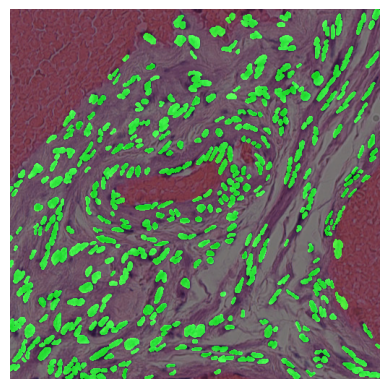

In [132]:
# Fetch IDs for TP, FP, FN
ids_tp, ids_fp, ids_fn = compare_and_fetch_ids(gt, pred)

tp_bool = np.isin(pred, ids_tp)
fp_bool = np.isin(pred, ids_fp)
fn_bool = np.isin(gt, ids_fn)
lbl = np.zeros(img.shape, dtype=np.uint8)
lbl[tp_bool] = 1
lbl[fp_bool] = 2
lbl[fn_bool] = 3
tp_rgb_bool = (lbl[:, :, :] == 1)
fp_rgb_bool = (lbl[:, :, :] == 2)
fn_rgb_bool = (lbl[:, :, :] == 3)
tps = np.all(tp_rgb_bool == True, axis=-1)
fps = np.all(fp_rgb_bool == True, axis=-1)
fns = np.all(fn_rgb_bool == True, axis=-1)
lbl[tps] = [0, 230, 0]
lbl[fps] = [200, 0, 0]
lbl[fns] = [0, 100, 230]

overlay = np.clip((img + 1.75 * lbl) / 2, 0, 255).astype(np.uint8)

plt.imshow(overlay)
plt.axis('off')
plt.show()